In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lightkurve import search_lightcurvefile

from thegrid import phase_coverage

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
obj = ['TIC 233211759', 'TIC 367853806']

In [4]:
lcf1 = search_lightcurvefile(obj[0]).download_all()
obj1 = lcf1.stitch()

lcf2 = search_lightcurvefile(obj[1]).download_all()
obj2 = lcf2.stitch()

/Users/james/opt/anaconda3/lib/python3.7/site-packages/lightkurve/lightcurvefile.py:47: LightkurveWarning: `LightCurveFile.header` is deprecated, please use `LightCurveFile.get_header()` instead.
  LightkurveWarning)
/Users/james/opt/anaconda3/lib/python3.7/site-packages/lightkurve/collections.py:213: LightkurveWarning: Stitching a `LightCurveFileCollection` which contains both SAP and PDCSAP_FLUX. Using PDCSAP_FLUX. You can remove this warning by explicitely using `LightCurveFileCollection.PDCSAP_FLUX.stitch()`.
  LightkurveWarning)
/Users/james/opt/anaconda3/lib/python3.7/site-packages/lightkurve/lightcurvefile.py:47: LightkurveWarning: `LightCurveFile.header` is deprecated, please use `LightCurveFile.get_header()` instead.
  LightkurveWarning)
/Users/james/opt/anaconda3/lib/python3.7/site-packages/lightkurve/collections.py:213: LightkurveWarning: Stitching a `LightCurveFileCollection` which contains both SAP and PDCSAP_FLUX. Using PDCSAP_FLUX. You can remove this warning by explicit

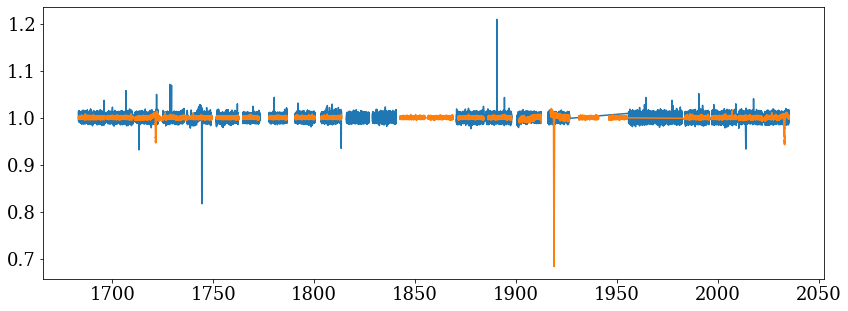

In [55]:
plt.figure(figsize=(14,5))
plt.plot(obj1.time, obj1.flux)
plt.plot(obj2.time, obj2.flux) # i like this one (orange) to start with

In [6]:
from scipy.optimize import curve_fit

def _gaus(x, a, b, x0, sigma):
    """
    a : the amplitude
    b : the constant offset
    x0 : the center of the Gaussian
    sigma : the width of the Gaussian
    """
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + b

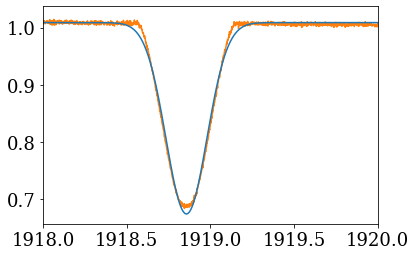

In [51]:
plt.plot(obj2.time, obj2.flux, c='C1')
plt.xlim(1918,1920)

p0 = (-0.75, 1, 1918.8, 0.2)
xx = np.where((obj2.time >= 1918) & (obj2.time < 1920))[0]
popt, pcov = curve_fit(_gaus, obj2.time[xx], obj2.flux[xx], p0=p0)
plt.plot(obj2.time, _gaus(obj2.time, *popt))

E1 = popt[2]

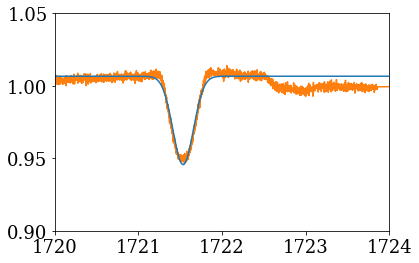

In [52]:
plt.plot(obj2.time, obj2.flux, c='C1')
plt.xlim(1720,1724)
plt.ylim(.9,1.05)

p0 = (-0.05, 1, 1721.5, 0.2)
xx = np.where((obj2.time >= 1720) & (obj2.time < 1722.5))[0]
popt, pcov = curve_fit(_gaus, obj2.time[xx], obj2.flux[xx], p0=p0)
plt.plot(obj2.time, _gaus(obj2.time, *popt))

E2 = popt[2]

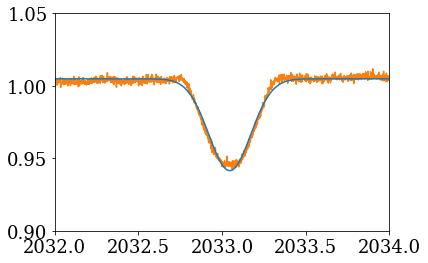

In [53]:
# interestingly, we got lucky in Sector 26, and a 3rd eclipse is avaiable now!
plt.plot(obj2.time, obj2.flux, c='C1')
plt.xlim(2032,2034)
plt.ylim(.9,1.05)

p0 = (-0.05, 1, 2033.1, 0.2)
xx = np.where((obj2.time >= 2032) & (obj2.time < 2034))[0]
popt, pcov = curve_fit(_gaus, obj2.time[xx], obj2.flux[xx], p0=p0)
plt.plot(obj2.time, _gaus(obj2.time, *popt))

E3 = popt[2]

In [56]:
P, is1, is2, PP, EE, coverage = phase_coverage(obj2.time, E1, E2, return_coverage=True, 
                                               minP=50, maxP=350, e_window=.5, downsample=True)

Text(0.5, 1.0, 'TIC 367853806')

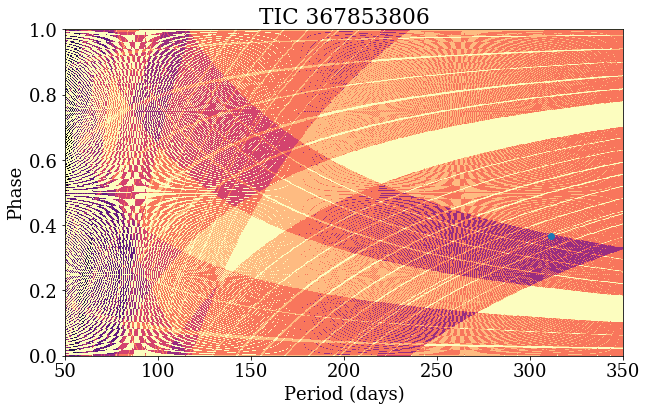

In [65]:
pc = ((E2 - E1) % P) / P

plt.figure(figsize=(10,6))
plt.pcolormesh(PP,EE, coverage, cmap=plt.cm.magma_r)
# plt.plot(P, pc, c='C0')
plt.scatter(E3-E2, ((E3 - E1) % (E3-E2)) / (E3-E2))
plt.xlabel('Period (days)')
plt.ylabel('Phase')
plt.title(obj[1])

Text(0, 0.5, '# Obs in Ecl Windows')

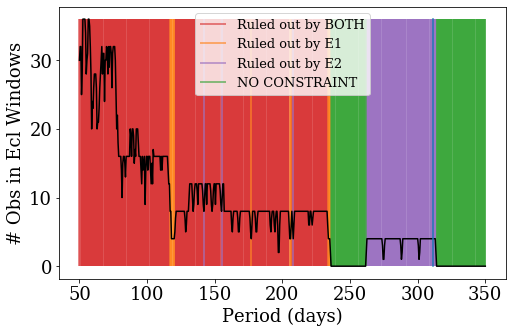

In [67]:
plt.figure(figsize=(8,5))
plt.plot(P, is1+is2, c='k')
plt.vlines(P[(is1 > 0) & (is2 > 0)], 0, max(is1+is2), color='C3', alpha=0.73, label='Ruled out by BOTH')
plt.vlines(P[(is1 > 0) & (is2 == 0)], 0, max(is1+is2), color='C1', alpha=0.73, label='Ruled out by E1')
plt.vlines(P[(is1 == 0) & (is2 > 0)], 0, max(is1+is2), color='C4', alpha=0.73, label='Ruled out by E2')
plt.vlines(P[(is1 == 0) & (is2 == 0)], 0, max(is1+is2), color='C2', alpha=0.73, label='NO CONSTRAINT')
plt.legend(fontsize=13)

# plt.plot([E3-E2, E3-E2], [0, max(is1+is2)])
# plt.fill_between([0,200], [0,0], [200000,200000],color='r')

plt.xlabel('Period (days)')
plt.ylabel('# Obs in Ecl Windows')

In [ ]:
# obj[0] needs some new features added to the code.
# i think it should: do the same thing it already does w/ the first 2 eclipse events
# but if there are multiple events (primary or secondary) it should mask them out too (?)
# and also "test" them as its searching
# the goal being: are there any sneaky shorter periods it could be folded it that aren't blocked?